In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from pyscfad import scf as scf_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer, Optimizer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized
from xcquinox.pyscf import eval_xc_gga_j2

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Pre-training PBE Networks

In [2]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

spbe_fx_lg = net.GGA_FxNet_sigma(depth=5, nodes=32, seed=92017, lower_rho_cutoff = 0)
spbe_fc_lg = net.GGA_FcNet_sigma(depth=5, nodes=32, seed=92017, lower_rho_cutoff = 0)

In [3]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [4]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

sinputs = jnp.stack([trf, tsf], axis=1)
siginputs = jnp.stack([strf, stgrf], axis=1)
sval = jnp.stack([vrf, vsf], axis=1)
print(sval.shape, sinputs.shape)

(3844, 2) (64009, 2)


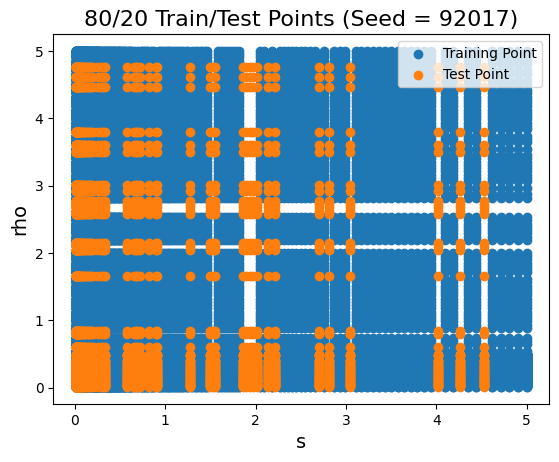

In [5]:
plt.scatter(trf, tsf, label='Training Point')
plt.scatter(vrf, vsf, label='Test Point')
plt.ylabel('rho', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.title('80/20 Train/Test Points (Seed = 92017)', fontsize=16)
plt.legend()

In [6]:
#create optimizers

PT_INIT_LR = 1e-3
PT_END_LR = 1e-5
PTSTEPS = 5000
PTDECAYBEGIN = int(PTSTEPS/2)
scheduler = optax.linear_schedule(
    init_value = PT_INIT_LR,
    transition_steps = PTSTEPS-PTDECAYBEGIN,
    transition_begin = PTDECAYBEGIN,
    end_value = PT_END_LR,
)

soptimizer_fx = optax.adam(learning_rate=scheduler)
soptimizer_fc = optax.adam(learning_rate=scheduler)

spt_pbe_fx = Pretrainer(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = PTSTEPS)
spt_pbe_fc = Pretrainer(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = PTSTEPS)
spt_pbe_fx_lg = Pretrainer(model = spbe_fx_lg, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = PTSTEPS)
spt_pbe_fc_lg = Pretrainer(model = spbe_fc_lg, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = PTSTEPS)

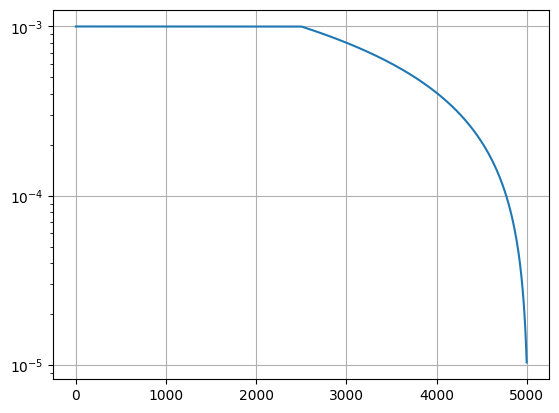

In [7]:
plt.plot(scheduler(np.arange(0, PTSTEPS)))
plt.yscale('log')
plt.grid()

In [8]:
snmx, snlx = spt_pbe_fx()
snmc, snlc = spt_pbe_fc()
snmxlg, snlxlg = spt_pbe_fx_lg()
snmclg, snlclg = spt_pbe_fc_lg()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.001767186591174214
Epoch 200: Loss = 0.00039659499770035783
Epoch 300: Loss = 0.00022332033715359134
Epoch 400: Loss = 0.0011457565966692363
Epoch 500: Loss = 0.00017366642962163577
Epoch 600: Loss = 0.0002653336692666036
Epoch 700: Loss = 0.0003112468689193662
Epoch 800: Loss = 0.0001346055857517686
Epoch 900: Loss = 0.00010070146010408569
Epoch 1000: Loss = 0.00025670977551852753
Epoch 1100: Loss = 0.0010566451358701306
Epoch 1200: Loss = 0.000595645022649573
Epoch 1300: Loss = 0.00012914703979307723
Epoch 1400: Loss = 0.00011287571798789195
Epoch 1500: Loss = 0.0002015784627982135
Epoch 1600: Loss = 0.0002029304379537099
Epoch 1700: Loss = 0.0002562705930783511
Epoch 1800: Loss = 0.0002723194356603262
Epoch 1900: Loss = 0.0007666284496760647
Epoch 2000: Loss = 0.000806872384558809
Epoch 2100: Loss = 0.0006942428483987912
Epoch 2200: Loss = 0.0007769110578897756
Epoch 2300: Loss = 0.0006686670236012941
Epoch 2400: Loss = 0.00012

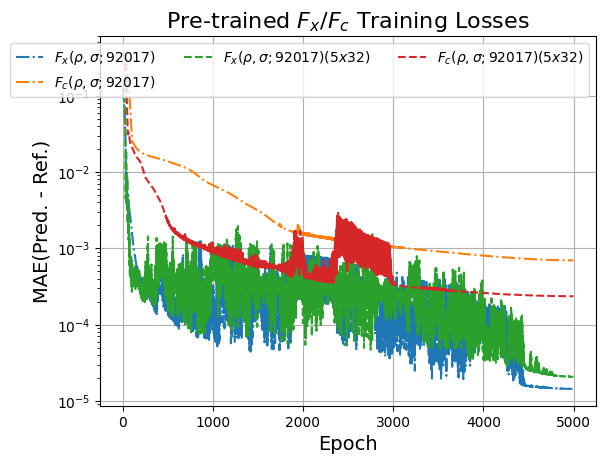

In [9]:
plt.plot(snlx, '-.', label='$F_x(\\rho,\\sigma;92017)$')
plt.plot(snlc, '-.', label='$F_c(\\rho,\\sigma;92017)$')
plt.plot(snlxlg, '--', label='$F_x(\\rho,\\sigma;92017) (5x32)$')
plt.plot(snlclg, '--', label='$F_c(\\rho,\\sigma;92017) (5x32)$')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
# plt.ylim(1e-5, 5e0)
plt.ylabel('MAE(Pred. - Ref.)', fontsize=14)
plt.title('Pre-trained $F_x$/$F_c$ Training Losses', fontsize=16)
plt.grid()
plt.legend(ncol=3)

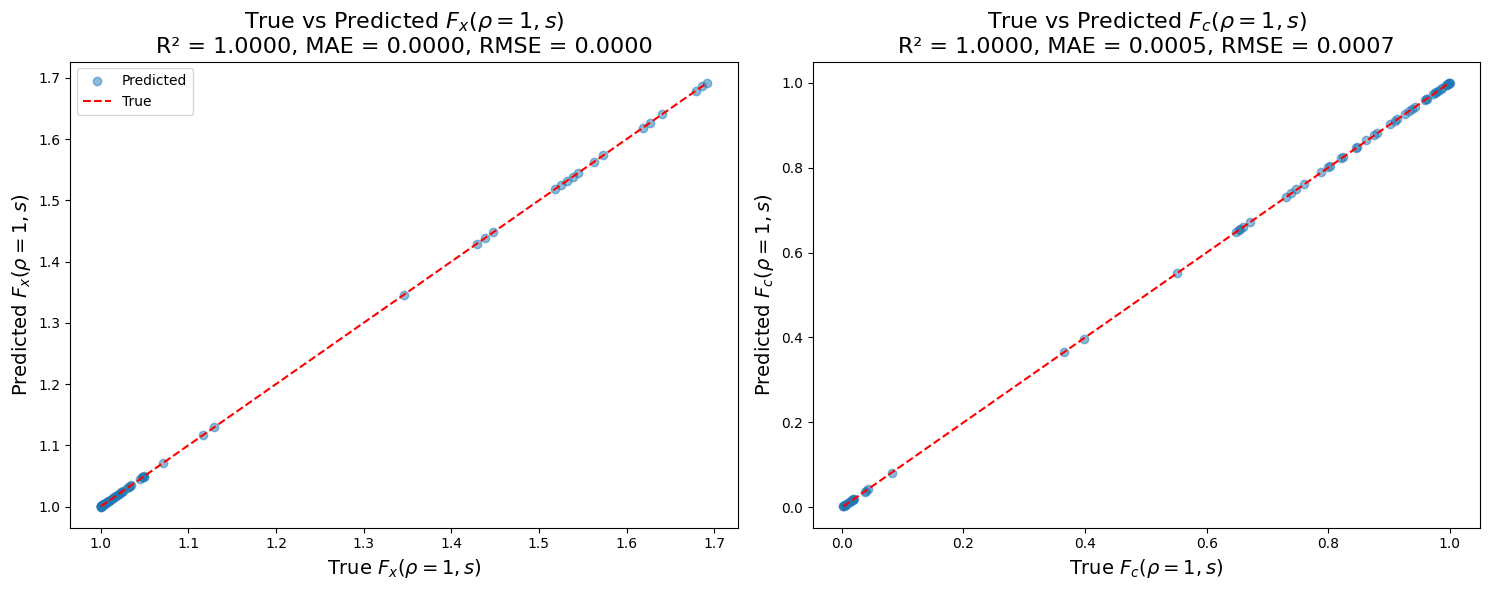

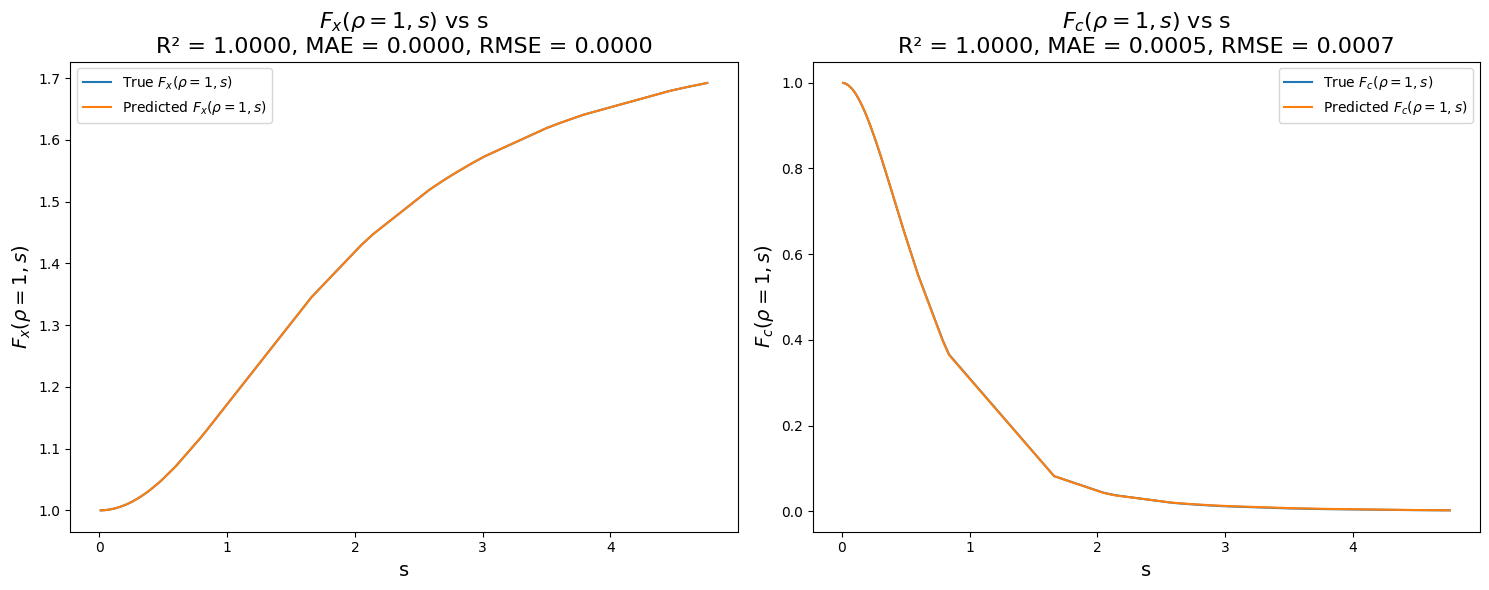

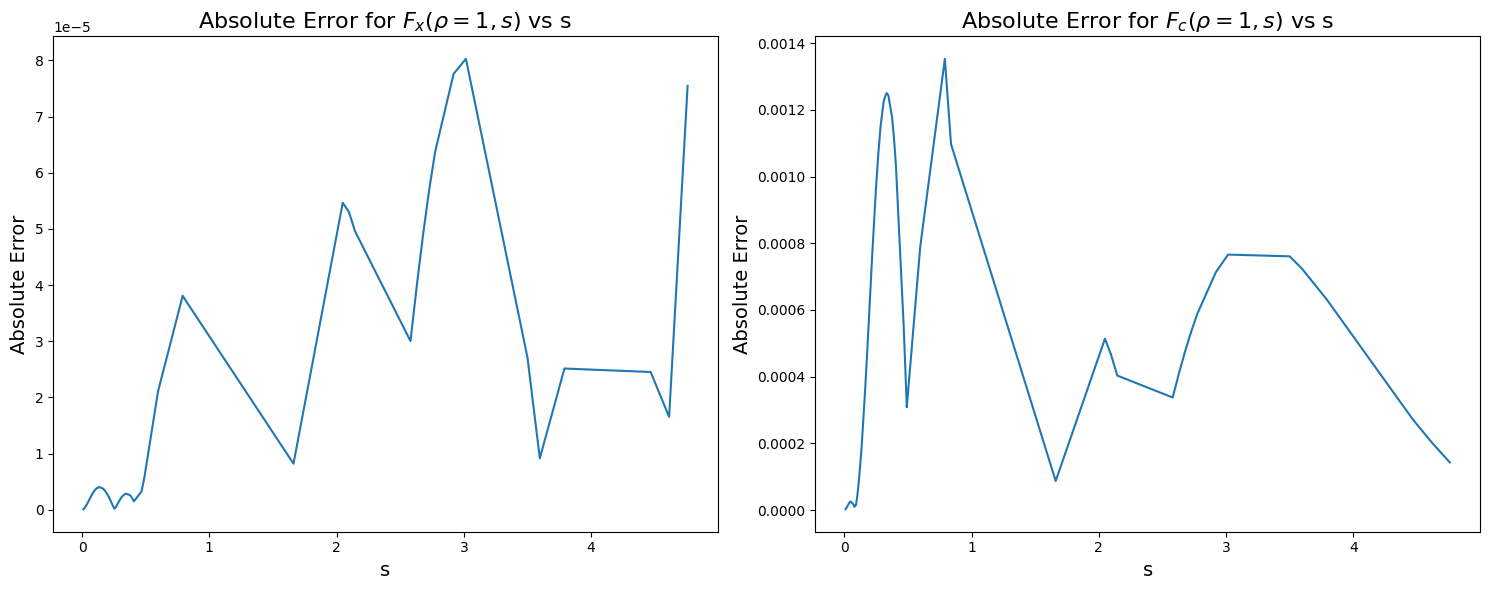

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000015
Root Mean Squared Error: 0.000027
Maximum Absolute Error: 0.000080

Fc Statistics:
R-squared: 0.999997
Mean Absolute Error: 0.000547
Root Mean Squared Error: 0.000691
Maximum Absolute Error: 0.001353


In [10]:
#for simplicity, we assume constant rho=1 for this test case and use the validation s; the 2d case will show the validation set using both
test_s = jnp.array(sorted(sv[val_inds]))
# test_rho = jnp.full_like(test_s, rv[val_inds].min())
test_rho = jnp.full_like(test_s, 1.0)
test_1d = jnp.stack([test_rho, test_s], axis=1)
# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho
test_1d = jnp.stack([test_rho, grad_rho_test**2], axis=1)

# Calculate true PBE enhancement factors
true_fx_test = PBE_Fx(test_rho, grad_rho_test)
true_fc_test = PBE_Fc(test_rho, grad_rho_test)

pred_fx = jax.vmap(snmx)(test_1d)
pred_fc = jax.vmap(snmc)(test_1d)

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)
# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5, label='Predicted')
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--', label='True')
ax1.set_xlabel('True $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_ylabel('Predicted $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'True vs Predicted $F_x(\\rho=1, s)$\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_ylabel('Predicted $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'True vs Predicted $F_c(\\rho=1, s)$\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True $F_x(\\rho=1, s)$')
ax1.plot(test_s, pred_fx, label='Predicted $F_x(\\rho=1, s)$')
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('$F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'$F_x(\\rho=1, s)$ vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True $F_c(\\rho=1, s)$')
ax2.plot(test_s, pred_fc, label='Predicted $F_c(\\rho=1, s)$')
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('$F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'$F_c(\\rho=1, s)$ vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('Absolute Error', fontsize=14)
ax1.set_title('Absolute Error for $F_x(\\rho=1, s)$ vs s', fontsize=16)

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('Absolute Error', fontsize=14)
ax2.set_title('Absolute Error for $F_c(\\rho=1, s)$ vs s', fontsize=16)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

In [11]:
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()], interpolation='none')
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    # ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    # ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    # ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
def plot_contour(true, pred, title, rho_values, s_values, ylog=True, cmap='inferno', pred_vminmax = None, true_vminmax = None, levels=25, ncbarticks=5, coffset = 1e-4):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    if true_vminmax:
        print('Custom vmin/vmax set -- reading.')
        tvmin, tvmax = true_vminmax
    else:
        tvmin = round(true.min(), 1)
        tvmax = round(true.max(), 1)
    print('Contour: true values - vmin/vmax = {}/{}'.format(tvmin, tvmax))
    im1 = ax1.contourf(s_values, rho_values, true, cmap=cmap, vmin = tvmin-coffset, vmax = tvmax+coffset, levels=np.linspace(tvmin, tvmax, levels, endpoint=True))
    im1.set_clim(vmin=true.min(), vmax=true.max())
    ax1.set_title(f'True {title}', fontsize=16)
    ax1.set_xlabel('$s$', fontsize=14)
    ax1.set_ylabel('$\\rho$', fontsize=14)
    cbar1 = fig.colorbar(im1, ax=ax1, ticks=np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True))
    
    if pred_vminmax:
        print('Custom vmin/vmax set -- reading.')
        pvmin, pvmax = pred_vminmax
    else:
        pvmin = round(pred.min(), 1)
        pvmax = round(pred.max(), 1)
    print('Contour: pred values - vmin/vmax = {}/{}'.format(pvmin,  pvmax))
    im2 = ax2.contourf(s_values, rho_values, pred, cmap=cmap, vmin = pvmin-coffset, vmax = pvmax+coffset, levels=np.linspace(pvmin, pvmax, levels, endpoint=True))
    ax2.set_title(f'Predicted {title}', fontsize=16)
    ax2.set_xlabel('$s$', fontsize=14)
    ax2.set_ylabel('$\\rho$', fontsize=14)
    cbar2 = fig.colorbar(im2, ax=ax2, ticks=np.linspace(pvmin, pvmax, num=ncbarticks, endpoint=True))
    cbar2.ax.get_yaxis().set_ticks(np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True)) 
    
    error = np.abs(true - pred)
    print('Contour: error values - vmin/vmax = {}/{}'.format(error.min(), error.max()))
    im3 = ax3.contourf(s_values, rho_values, error, cmap=cmap, vmin = error.min(), vmax = error.max(), levels=np.linspace(error.min(), error.max(), levels, endpoint=True))
    ax3.set_title(f'Absolute Error for {title}', fontsize=16)
    ax3.set_xlabel('$s$', fontsize=14)
    ax3.set_ylabel('$\\rho$', fontsize=14)
    cbar3 = fig.colorbar(im3, ax=ax3, ticks=np.linspace(error.min(), error.max(), num=ncbarticks, endpoint=True))
    # im3.set_clim(vmin=error.min(), vmax=error.max())
    
    if ylog:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()


Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000015
Root Mean Squared Error: 0.000027
Maximum Absolute Error: 0.000080

Fc Statistics:
R-squared: 0.999987
Mean Absolute Error: 0.000725
Root Mean Squared Error: 0.001453
Maximum Absolute Error: 0.015716
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 8.592101230497917e-08/8.026753960699295e-05


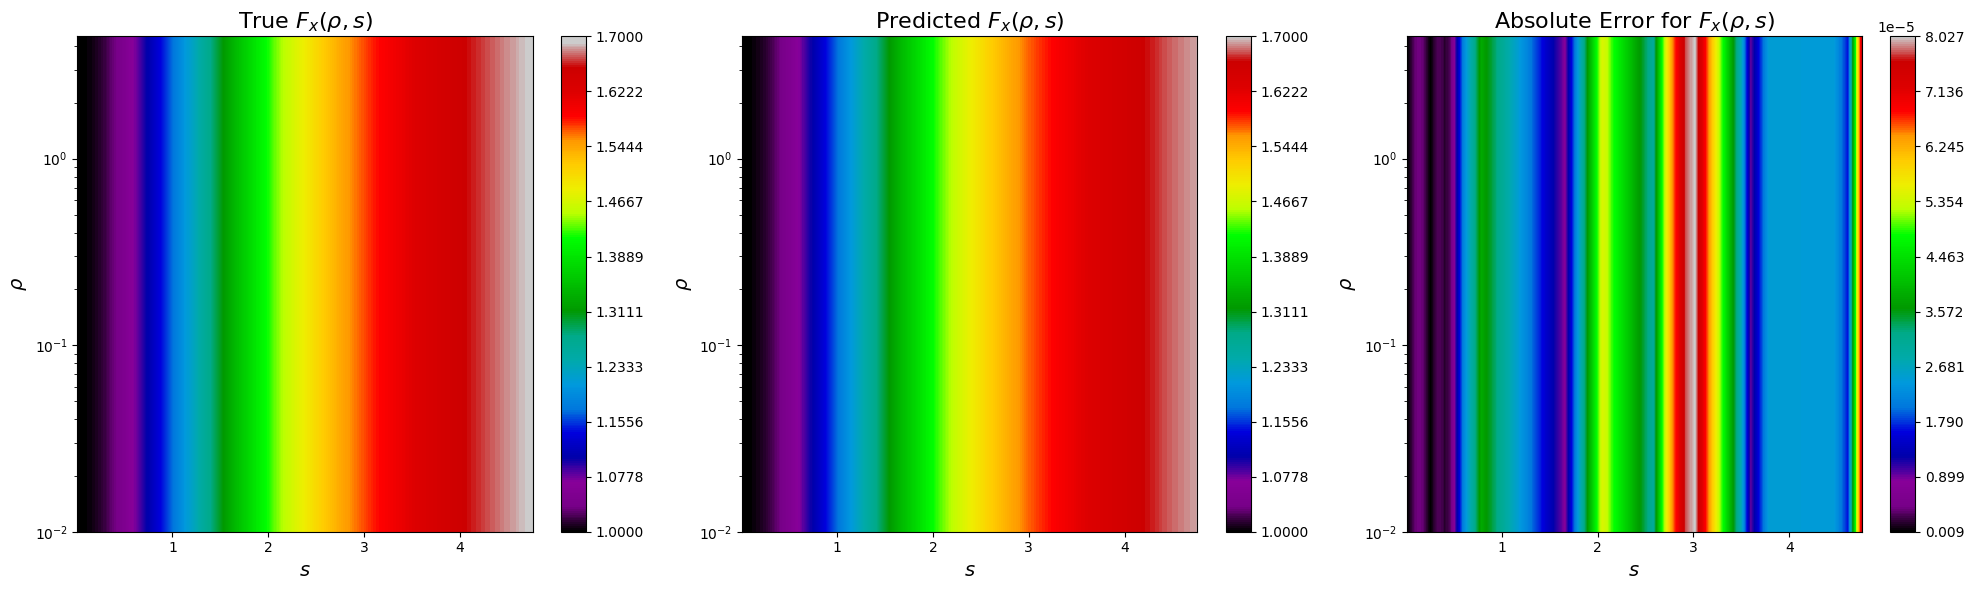

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 2.2592751003358558e-09/0.015716265807205976


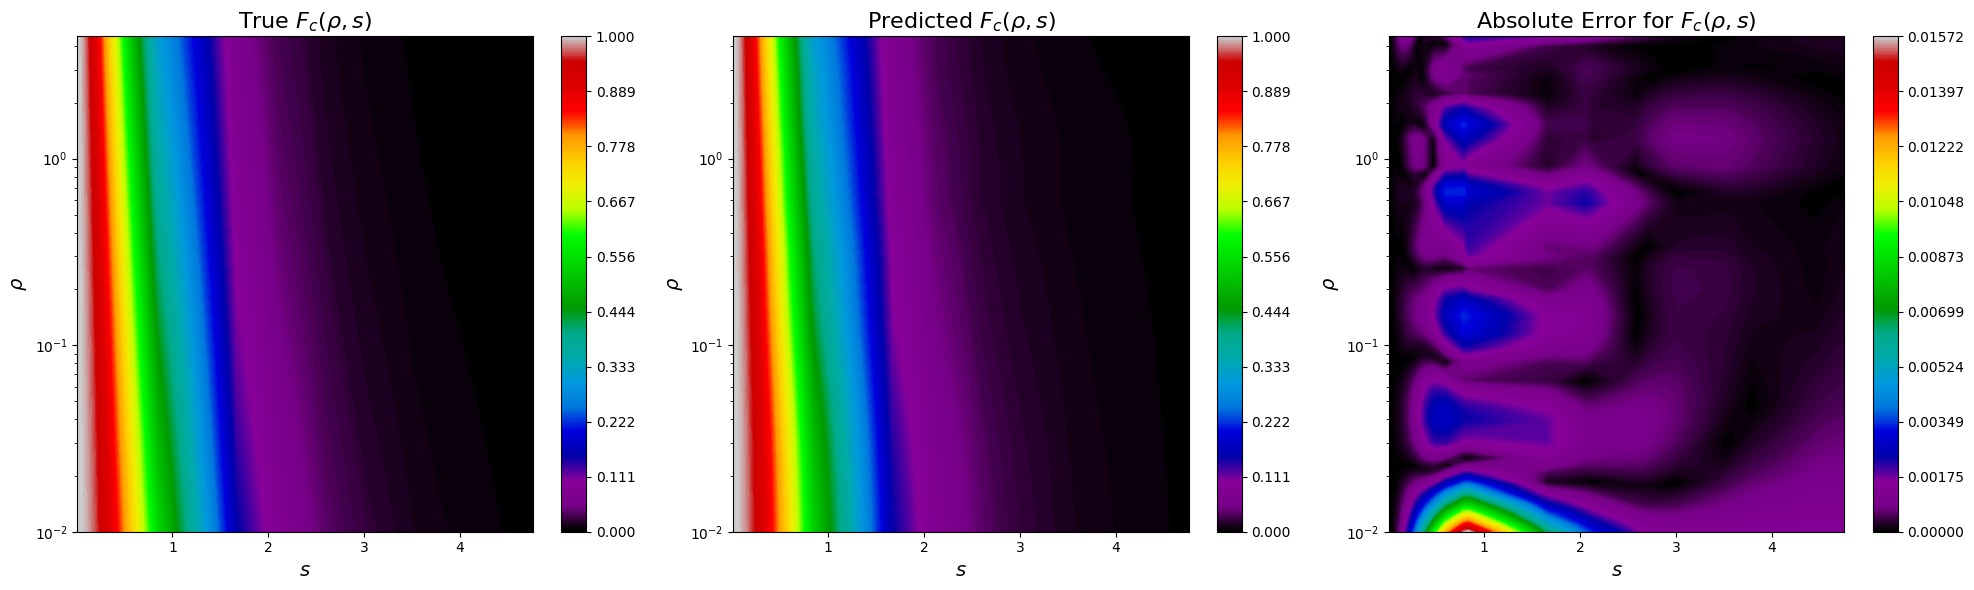

In [12]:
test_s = jnp.array(sorted(ssv[sval_inds]))
test_rho = jnp.array(sorted(srv[sval_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()**2], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(snmx)(img_sinps)
pred_fc = jax.vmap(snmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


# Optimizing PBE Networks

We will be using 
- water's atomization energy (+total energies for atomic constituents calculated to even do the calculation)
- just the S(2) subset from my optimally representative subsets
- combination of both

Training on H requires a one-shot calculation for some reason, as the SCF cycle yields nans.

In [13]:
from ase.io import read
trj = read('/home/awills/Documents/Research/xcquinox/scripts/script_data/training_subsets/06wf/subat_ref.traj', ':')
for idx, at in enumerate(trj):
    print(idx, at, at.symbols, at.info)
    if str(at.symbols) in ['Cl2', 'HF2', 'FH']:
        print(at.get_chemical_symbols(), at.get_positions())

0 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)) N2 {'N2': True, 'name': 'Dinitrogen', 'n_rad': 6, 'n_ang': 10, 'pol': False, 'target_energy': -0.36405261150717777, 'energy': -109.41916258265782, 'atomization': -0.36405261150717777, 'atomization_ev': -9.906376144900815, 'atomization_H': -0.36405261150717777, 'calc_energy': -109.41916258265782, 'e_calc': -109.41916258265782}
1 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) LiF {'LiF': True, 'name': 'Lithium fluoride', 'n_rad': 3, 'n_ang': 15, 'pol': False, 'target_energy': -0.22243004393513086, 'energy': -107.3059420504875, 'atomization': -0.22243004393513086, 'atomization_ev': -6.052629788935811, 'atomization_H': -0.22243004393513086, 'calc_energy': -107.3059420504875, 'e_calc': -107.3059420504875}
2 Atoms(symbols='ClH', pbc=False, calculator=SinglePointCalculator(...)) ClH {'HCl': True, 'name': 'Hydrogen chloride', 'n_rad': 3, 'n_ang': 10, 'target_energy': -0.17123597861668197, 'energy': 

In [14]:
#reference energies:
#[H_TE, O_TE, H2O_AE] <- step 1
kjMol_to_H = 2625.5
refs1 = [-0.5, -75.0673, -974.94/kjMol_to_H]
#[Cl_TE, Cl2_AE, HF+F -> H+F2 barrier]
refs2 = [-460.148, -0.09454200500963746, 0.16920860069537955]
refs3 = refs1 + refs2

mol_params = {'H': {'atoms':['H'], 'coords': [[0,0,0]], 'spin':1, 'charge':0},
              'O': {'atoms':['O'], 'coords':[[0,0,0]], 'spin':2, 'charge':0},
              'H2O': {'atoms':['O','H','H'], 'coords':[[0,0,0],[0,-0.757,0.587],[0,0.757,0.587]], 'spin':0,'charge':0},
              'Cl':{'atoms':['Cl'], 'coords':[[0,0,0]], 'spin':1, 'charge':0},
              'Cl2':{'atoms':['Cl','Cl'], 'coords': [ [0,0,1.008241], [0,0,-1.008241] ], 'spin':0, 'charge':0},
              'HF2':{'atoms':['H', 'F', 'F'], 'coords':[ [0,0,-2.2312757],[0,0,-0.61621628],[0,0,0.8641358] ], 'spin':1, 'charge':0},
              'FH':{'atoms':['F', 'H'], 'coords':[ [0,0,0.09153813], [0,0,-0.82384424] ], 'spin':0, 'charge':0},
              'F':{'atoms':['F'], 'coords':[ [0,0,0] ], 'spin':1, 'charge':0}
             }
mol_dct = {k:0 for k in mol_params.keys()}
for sys in mol_dct.keys():
    atstr = ''
    print(sys)
    for idx, at in enumerate(mol_params[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *mol_params[sys]['coords'][idx])
    print(atstr)
    mol = gto_ad.Mole(atom = atstr, charge = mol_params[sys]['charge'], spin = mol_params[sys]['spin'])
    mol.basis = 'dzvp'
    mol.build()
    mol.max_memory = 32000

    mol_dct[sys] = mol

mols1 = [mol_dct['H'], mol_dct['O'], mol_dct['H2O']]
mols2 = [mol_dct['Cl'], mol_dct['Cl2'], mol_dct['HF2'], mol_dct['FH'], mol_dct['F']]
mols3 = mols1+mols2

H
H 0 0 0

O
O 0 0 0

H2O
O 0 0 0
H 0 -0.757 0.587
H 0 0.757 0.587

Cl
Cl 0 0 0

Cl2
Cl 0 0 1.008241
Cl 0 0 -1.008241

HF2
H 0 0 -2.2312757
F 0 0 -0.61621628
F 0 0 0.8641358

FH
F 0 0 0.09153813
H 0 0 -0.82384424

F
F 0 0 0



In [15]:
@eqx.filter_value_and_grad
def opt_loss1_oneshot(model, mols, refs):
    #assumes mols are [H, O, H2O]
    #assumes refs are [H_TE, O_TE, H2O_AE]
    total_loss = 0
    preds = []
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        mf.max_cycle = -1
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        preds.append(mf.e_tot)
        if idx == 1: #don't do total energy loss with H or water, just the O atom
            total_loss += abs(mf.e_tot - refs[idx])
    water_ae = preds[-1] - (2*preds[0] + preds[1])
    water_ae_loss = abs(water_ae - refs[2])
    # print('Loss calculation complete.')
    # print('preds, refs = ', preds, refs)
    # print('Predicted/Reference/Loss Water AE: {}/{}/{}'.format(water_ae, refs[2], water_ae_loss))
    total_loss += water_ae_loss
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss1(model, mols, refs):
    #assumes mols are [H, O, H2O]
    #assumes refs are [H_TE, O_TE, H2O_AE]
    total_loss = 0
    preds = []
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        if idx == 0:
            mf.max_cycle = -1
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        preds.append(mf.e_tot)
        if idx == 1: #don't do total energy loss with H or water, just the O atom
            total_loss += abs(mf.e_tot - refs[idx])
    water_ae = preds[-1] - (2*preds[0] + preds[1])
    water_ae_loss = abs(water_ae - refs[2])
    # print('Loss calculation complete.')
    # print('preds, refs = ', preds, refs)
    # print('Predicted/Reference/Loss Water AE: {}/{}/{}'.format(water_ae, refs[2], water_ae_loss))
    total_loss += water_ae_loss
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss2(model, mols, refs):
    #assumes mols are [Cl, Cl2, HF2, FH, F]
    #assumes refs are [Cl_TE, Cl2_AE, HF2->FH+F_BH]
    total_loss = 0
    preds = []
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        preds.append(mf.e_tot)
        if idx < 1: #don't do total energy loss with anything but chlorine atom
            total_loss += abs(mf.e_tot - refs[idx])
    cl2_ae = preds[1] - 2*preds[0]
    hf2_bh = preds[2] - (preds[3] + preds[4])
    cl2_ae_loss = abs(cl2_ae - refs[1])
    hf2_bh_loss = abs(hf2_bh - refs[2])
    # print('Loss calculation complete.')
    # print('preds, refs = ', preds, refs)
    # print('Predicted/Reference/Loss Cl2 AE: {}/{}/{}'.format(cl2_ae, refs[1], cl2_ae_loss))
    # print('Predicted/Reference/Loss HF2->HF+F BH: {}/{}/{}'.format(hf2_bh, refs[2], hf2_bh_loss))
    total_loss += cl2_ae_loss
    total_loss += hf2_bh_loss
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss3(model, mols, refs):
    #assumes mols are [H, O, H2O, Cl, Cl2, HF2, FH, F]
    #assumes refs are [H_TE, O_TE, H2O_AE, Cl_TE, Cl2_AE, HF2->FH+F_BH]
    total_loss = 0
    preds = []
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        if idx == 0:
            mf.max_cycle = -1
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        preds.append(mf.e_tot)
        if idx in [1, 3]: #don't do total energy loss with anything but single atoms excluding H
            total_loss += abs(mf.e_tot - refs[idx])
    water_ae = preds[2] - (2*preds[0] + preds[1])
    cl2_ae = preds[4] - 2*preds[3]
    hf2_bh = preds[5] - (preds[6] + preds[7])

    water_ae_loss = abs(water_ae - refs[2])
    cl2_ae_loss = abs(cl2_ae - refs[4])
    hf2_bh_loss = abs(hf2_bh - refs[5])
    # print('Loss calculation complete.')
    # print('preds, refs = ', preds, refs)
    # print('Predicted/Reference/Loss Water AE: {}/{}/{}'.format(water_ae, refs[2], water_ae_loss))
    # print('Predicted/Reference/Loss Cl2 AE: {}/{}/{}'.format(cl2_ae, refs[4], cl2_ae_loss))
    # print('Predicted/Reference/Loss HF2->HF+F BH: {}/{}/{}'.format(hf2_bh, refs[5], hf2_bh_loss))

    total_loss += water_ae_loss
    total_loss += cl2_ae_loss
    total_loss += hf2_bh_loss
    return total_loss[..., jnp.newaxis][0]

In [16]:
class RXCModel(eqx.Module):
    xnet: eqx.Module
    cnet: eqx.Module

    def __init__(self, xnet, cnet):
        self.xnet = xnet
        self.cnet = cnet
        
    def __call__(self, inputs):
        #this generate epsilon, not exc -- divide end result by rho when needed
        rho = inputs[0]
        sigma = inputs[1]
        # print('RXCModel call - inputs {}'.format(inputs))
        return rho*(lda_x(rho)*jax.vmap(self.xnet)(inputs[..., jnp.newaxis]) + pw92c_unpolarized(rho)*jax.vmap(self.cnet)(inputs[..., jnp.newaxis])).flatten()[0]
        # return rho*(lda_x(rho)*self.xnet(inputs) + pw92c_unpolarized(rho)*self.cnet(inputs)).flatten()[0]

In [17]:
pt_model = RXCModel(xnet = snmx, cnet = snmc)
pt_model_lg = RXCModel(xnet = snmxlg, cnet = snmclg)

In [18]:
OPT_INIT_LR = 5e-3
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 50
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt1_1shot = optax.adam(learning_rate=scheduler)
opt_opt1_1shot_lg = optax.adam(learning_rate=scheduler)
opt_opt1 = optax.adam(learning_rate=scheduler)
opt_opt1lg = optax.adam(learning_rate=scheduler)
opt_opt2 = optax.adam(learning_rate=scheduler)
opt_opt3 = optax.adam(learning_rate=scheduler)

optnet1_o_1shot = Optimizer(model=pt_model, optim=opt_opt1_1shot, mols = mols1, refs = refs1, loss=opt_loss1_oneshot, print_every=1, steps=OPTSTEPS)

optnet1_o_1shot_lg = Optimizer(model=pt_model_lg, optim=opt_opt1_1shot_lg, mols = mols1, refs = refs1, loss=opt_loss1_oneshot, print_every=1, steps=OPTSTEPS)

optnet1_o = Optimizer(model=pt_model, optim=opt_opt1, mols = mols1, refs = refs1, loss=opt_loss1, print_every=1, steps=OPTSTEPS)

optnet1_olg = Optimizer(model=pt_model_lg, optim=opt_opt1lg, mols = mols1, refs = refs1, loss=opt_loss1, print_every=1, steps=OPTSTEPS)

optnet2_o = Optimizer(model=pt_model, optim=opt_opt2, mols = mols2, refs = refs2, loss=opt_loss2, print_every=1, steps=OPTSTEPS)

optnet3_o = Optimizer(model=pt_model, optim=opt_opt3, mols = mols3, refs = refs3, loss=opt_loss3, print_every=1, steps=OPTSTEPS)

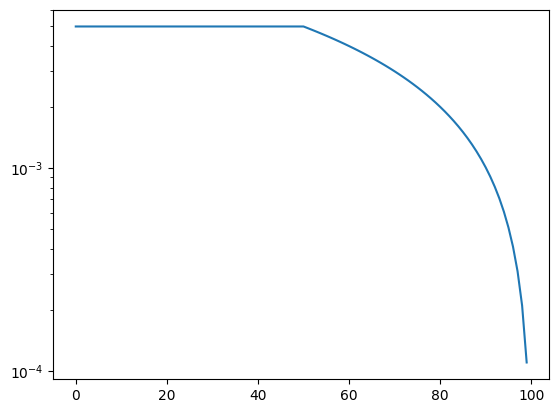

In [19]:
plt.plot(scheduler(np.arange(0, OPTSTEPS)))
plt.yscale('log')

In [20]:
optnet1_oslg, optnet1l_oslg = optnet1_o_1shot_lg()
optnet1_os, optnet1l_os = optnet1_o_1shot()

(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)
v2 shape (4524, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
Epoch 0: Loss = 0.5840794944249075
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)
v2 shape (4524, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
Epoch 1: Loss = 0.5415983510424189
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)
v2 shape (4524, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
Epoch 2: Loss = 0.47228280669828343
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)
v2 shape (4524, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
Epoch 3: Loss = 0.4005140422877907
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)
v2 shape (4524, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
Epoch 4: Loss = 0.32639648294624585
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for 

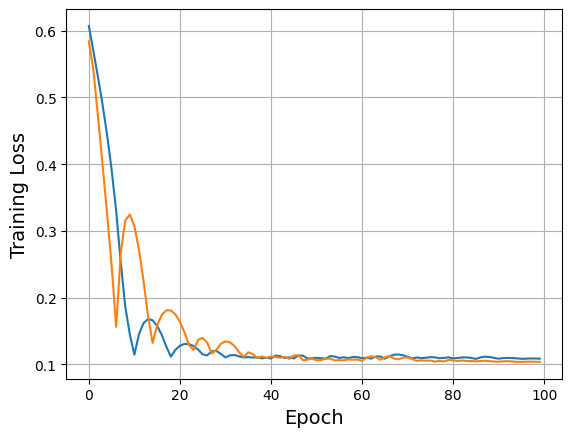

In [21]:
plt.plot(optnet1l_os)
plt.plot(optnet1l_oslg)
# plt.plot(np.array(optnet1l_oslg)-np.array(optnet1l_os))
# plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.grid()

In [ ]:
optnet1, optnet1l = optnet1_o()

(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 0: Loss = 0.7207850527995368
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 1: Loss = 0.6778610522253052
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.



/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 2: Loss = 0.6536921402618197
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 3: Loss = 0.6279712071440946
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.



/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 4: Loss = 0.6125971044573879
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 5: Loss = 0.6145939726726033
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 6: Loss = 0.6117202347280772
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 7: Loss = 0.6024136446553234
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 8: Loss = 0.5811579936197211
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 9: Loss = 0.5817403446152218
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 10: Loss = 0.5583944222069397
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 11: Loss = 0.5526140451291559
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 12: Loss = 0.5332645846081283
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 13: Loss = 0.5195890988463197
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 14: Loss = 0.526258874893822
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 15: Loss = 0.4933356457312022
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 16: Loss = 0.5635990319621647
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 17: Loss = 0.5253606865081173
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 18: Loss = 0.5308835488079728
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 19: Loss = 0.528265801018444
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 20: Loss = 0.5405759237705843
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 21: Loss = 0.5657489720984279
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 22: Loss = 0.5630868077325693
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 23: Loss = 0.5544966067237829
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 24: Loss = 0.5525517360822454
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 25: Loss = 0.5534362000780197
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 26: Loss = 0.5580239214072924
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 27: Loss = 0.564161421726036
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 28: Loss = 0.5631124597195287
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 29: Loss = 0.5659231261549797
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 30: Loss = 0.5580849566110351
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 31: Loss = 0.5662219235757908
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 32: Loss = 0.5551462928089086
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 33: Loss = 0.559687604442056
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 34: Loss = 0.5860538693833865
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 35: Loss = 0.5546123512130043
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 36: Loss = 0.5802930305738363
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 37: Loss = 0.6167755064547384
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 38: Loss = 0.559531678679287
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 39: Loss = 0.5747052320550188
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 40: Loss = 0.5609823798567055
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 41: Loss = 0.5557329333455192
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 42: Loss = 0.5727319070725463
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 43: Loss = 0.5619782267761713
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 44: Loss = 0.5680550184489539
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 45: Loss = 0.5604212242631468
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 46: Loss = 0.7554351036418672
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 47: Loss = 0.57886678270088
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 48: Loss = 0.5811423980926185
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 49: Loss = 0.5611628711262517
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 50: Loss = 0.5639722841608068
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 51: Loss = 0.5711931884196366
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.



/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8980, 2, 2)
(8980, 2)
v2 shape (8980, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Epoch 52: Loss = 0.5621471932258493
(2262, 2)
v2 shape (2262, 2, 2)

WARN: Invalid number of electrons 8 for RHF method.

(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (4524, 2, 2)
(4524, 2)
v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (4524, 2, 2)
(4524, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


In [ ]:
optnet1lg, optnet1llg = optnet1_olg()

In [ ]:
optnet2, optnet2l = optnet2_o()

In [ ]:
optnet3, optnet3l = optnet3_o()

In [ ]:
plt.plot(optnet1l)
plt.plot(optnet2l)
plt.plot(optnet3l)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.grid()

# Testing - WATER27 Dataset

In [22]:
w27systems = {
    'OHmH2O4c4' : { 'atoms' : ['H', 'H', 'H', 'H', 'O', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0267918, 1.5818251, 0.2834249], [1.5818251, 0.0267918, 0.2834249], [0.0267918, -1.5818251, 0.2834249], [-1.5818251, -0.0267918, 0.2834249], [0.0, 0.0, 0.9578999], [0.0, 0.0, 1.9177035], [0.0314199, 2.4185664, -0.2529905], [2.4185664, -0.0314199, -0.2529905], [-0.0314199, -2.4185664, -0.2529905], [-2.4185664, 0.0314199, -0.2529905], [0.843048, 2.2785225, -0.7493353], [2.2785225, -0.843048, -0.7493353], [-0.843048, -2.2785225, -0.7493353], [-2.2785225, 0.843048, -0.7493353]], 'charge' : -1, 'spin' : 0 },
    'H2O8d2d' : { 'atoms' : ['O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.4645552, -1.4645552, 1.3497067], [-1.4645552, 1.4645552, -1.3497067], [1.4645552, -1.4645552, -1.3497067], [1.4645552, 1.4645552, 1.3497067], [-1.5346654, -1.5346654, 0.3622554], [-1.5346654, 1.5346654, -0.3622554], [1.5346654, -1.5346654, -0.3622554], [1.5346654, 1.5346654, 0.3622554], [-2.0896636, -2.0896636, 1.7251112], [-2.0896636, 2.0896636, -1.7251112], [2.0896636, -2.0896636, -1.7251112], [2.0896636, 2.0896636, 1.7251112], [-1.4052886, -1.4052886, -1.3390082], [-1.4052886, 1.4052886, 1.3390082], [1.4052886, -1.4052886, 1.3390082], [1.4052886, 1.4052886, -1.3390082], [-1.5526158, -0.4620645, -1.5268989], [-1.5526158, 0.4620645, 1.5268989], [1.5526158, -0.4620645, 1.5268989], [-0.4620645, -1.5526158, -1.5268989], [0.4620645, 1.5526158, -1.5268989], [0.4620645, -1.5526158, 1.5268989], [-0.4620645, 1.5526158, 1.5268989], [1.5526158, 0.4620645, -1.5268989]], 'charge' : 0, 'spin' : 0 },
    'H2O20es' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.4449507, -2.3192362, 1.3852172], [0.9523409, -1.4842602, 1.5288696], [2.3694569, -2.1139495, 1.6116655], [1.4198689, -2.4626094, -1.4007113], [1.4412349, -2.4945724, -0.4194091], [0.7771617, -3.1468464, -1.6575718], [0.0068371, 0.0172196, 1.4027157], [0.3893324, 0.9065634, 1.5625403], [-0.9609503, 0.0503272, 1.5609821], [-2.7367283, -0.0717073, 1.3588421], [-2.7881947, -0.0946107, 0.3779034], [-2.9785985, -0.9717563, 1.6413949], [4.0454641, 1.4627919, -1.4612681], [4.7881071, 1.7639854, -1.9912934], [4.0333238, 0.4731882, -1.5313495], [-1.0008037, 4.2249605, 1.4982864], [-1.152189, 5.0082615, 2.0335617], [-1.8328395, 3.6856129, 1.5416327], [-3.2272404, 2.7492225, -1.5453255], [-3.8412573, 3.2117349, -2.121788], [-2.3703373, 3.2485931, -1.5888707], [0.061546, -0.0608668, -1.3504788], [0.5404095, -0.8892136, -1.5688996], [0.0525024, -0.0517312, -0.3661063], [1.3505765, 2.3624375, -1.4255501], [2.2943427, 2.2180386, -1.6165285], [0.9255618, 1.4877943, -1.5595341], [4.0797114, -1.2705898, 1.5101742], [4.8184302, -1.5307198, 2.0667554], [4.0088205, -0.2833084, 1.5792807], [-0.9118416, 4.114684, -1.3968277], [-0.8699572, 4.3289684, -0.4493559], [-0.0897473, 3.6305502, -1.5859742], [-2.6850195, -0.0424816, -1.4274401], [-2.9831436, 0.8560006, -1.6562177], [-1.7132338, -0.0438086, -1.5635337], [-3.1295491, -2.8665515, -1.3299376], [-3.1140901, -1.9191429, -1.5480976], [-3.3032413, -2.9025862, -0.3736924], [1.224434, 2.4780105, 1.3595377], [0.5812433, 3.1657978, 1.6076146], [1.272843, 2.5161003, 0.3793006], [-0.812813, -4.2331318, -1.5239325], [-0.9466607, -5.0213678, -2.0566534], [-1.663369, -3.7232425, -1.5543692], [-3.2498861, 2.7544587, 1.3479831], [-3.1924627, 1.8120206, 1.5790401], [-3.4347595, 2.7666931, 0.3928574], [4.0373837, -1.2313563, -1.3812425], [3.2335259, -1.7195098, -1.6240819], [4.1604036, -1.4012254, -0.4312943], [-3.094015, -2.885118, 1.5661544], [-2.2180185, -3.3510614, 1.5943976], [-3.6898242, -3.3867826, 2.1285951], [-0.7332536, -4.1659349, 1.3697764], [0.0709231, -3.6538397, 1.5619151], [-0.6879895, -4.3597798, 0.4176959], [3.9098072, 1.4164687, 1.4257218], [3.0660482, 1.8495739, 1.636771], [4.0554225, 1.5928403, 0.4801529]], 'charge' : 0, 'spin' : 0 },
    'H2O20fs' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-0.4674337, -1.4156432, 2.3424832], [-0.5103881, -0.5327785, 2.7383509], [-1.154371, -1.4135419, 1.6390602], [-1.1804953, -4.411489, -2.0217879], [-1.6005951, -5.0804995, -2.5684061], [-1.6296589, -4.4443491, -1.1306922], [-0.3890822, -4.3416186, 2.3649217], [-0.4122318, -3.4254374, 2.6780297], [0.495447, -4.4516812, 1.9766411], [-2.370827, -1.4010748, 0.3317388], [-2.7687053, -0.5190604, 0.3764393], [-1.9008133, -1.4312776, -0.5314561], [-1.0412215, -1.5773429, -2.0898648], [-0.0740952, -1.5478577, -1.9182976], [-1.2210828, -2.5028893, -2.3334269], [1.6403031, -4.3519848, -1.6030968], [0.6907637, -4.4791178, -1.78646], [1.8234428, -3.4332488, -1.8548591], [-2.332464, -4.3191108, 0.3710663], [-1.6749165, -4.4161499, 1.0945673], [-2.663344, -3.4130595, 0.4587135], [1.6787401, -1.4676579, -1.5895498], [1.8042491, -1.4683808, -0.6135222], [1.9691284, -0.5921861, -1.8871045], [2.0177788, -1.5700244, 1.1457336], [1.1343262, -1.5367783, 1.5764315], [2.3187166, -2.4899023, 1.2541941], [2.1824622, -4.3930741, 1.0311736], [2.8554348, -5.0463468, 1.2384494], [2.0031126, -4.4627308, 0.0573709], [-0.4152401, 4.3842505, 2.2876138], [-0.5679834, 5.06537, 2.9479304], [-1.1127701, 4.487654, 1.6038264], [-1.1046614, 1.2760042, -2.0786808], [-1.2737935, 0.3860585, -2.4278927], [-1.5421398, 1.2973941, -1.1984656], [-0.3343417, 1.482161, 2.3157837], [0.5348035, 1.4101401, 1.8606636], [-0.3797162, 2.3986009, 2.6294913], [-2.2749913, 4.3768946, 0.233996], [-1.7988517, 4.3462894, -0.6427551], [-2.9812564, 5.0213482, 0.1371479], [-0.9933823, 4.1431644, -2.0843627], [-0.0298852, 4.2701065, -2.0022747], [-1.1087883, 3.2216193, -2.3688039], [1.6344386, 1.3954288, -1.6918288], [0.6638061, 1.3608461, -1.8412994], [1.8936812, 2.3076806, -1.9040298], [-2.3215084, 1.4785163, 0.3929266], [-2.6250091, 2.4001087, 0.3878313], [-1.6192612, 1.4525318, 1.0812056], [1.8145415, 4.2491098, -1.649936], [2.4020909, 4.8900295, -2.0585139], [1.9809374, 4.28431, -0.6721155], [2.1692949, 4.1320169, 1.0124794], [2.3810198, 3.2011114, 1.193355], [1.3372868, 4.3008339, 1.4866278], [2.0958108, 1.2695995, 1.0227267], [2.4183264, 0.3768526, 1.2284758], [1.9353623, 1.2702628, 0.0520364]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-1.1997281, 0.0290201, 0.115747], [-1.6314241, -0.7333199, 0.5284065], [-1.6940017, 0.2956236, -0.6724225], [1.1997281, -0.0290201, 0.115747], [0.0, 0.0, 0.056538], [1.6940017, -0.2956236, -0.6724225], [1.6314241, 0.7333199, 0.5284065]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O4cs' : { 'atoms' : ['O', 'O', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[0.7941268, -0.1580495, 2.0660393], [-0.026599, -1.4686255, 0.0], [0.8535437, 1.317568, 0.7632695], [-0.0492092, 0.0556879, 2.4738562], [0.7060196, 1.9061093, 0.0], [0.8535437, 1.317568, -0.7632695], [0.7941268, -0.1580495, -2.0660393], [-0.0492092, 0.0556879, -2.4738562], [0.5253029, -0.7667811, -1.2898742], [-2.0377301, 0.3905888, 0.0], [-1.3911533, 1.1099929, 0.0], [-1.4545847, -0.4079553, 0.0], [0.5253029, -0.7667811, 1.2898742], [-0.0434809, -2.4269609, 0.0]], 'charge' : -1, 'spin' : 0 },
    'H3Op' : { 'atoms' : ['O', 'H', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.2080105], [0.4697566, 0.8136422, 0.0693368], [0.4697566, -0.8136422, 0.0693368], [-0.9395131, 0.0, 0.0693368]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O2' : { 'atoms' : ['H', 'O', 'H', 'H', 'O', 'H', 'O', 'H'], 'coords' : [[-1.4579587, 0.0040843, 0.0244594], [-2.4291204, 0.0733055, -0.3263151], [0.0, 0.0, 1.4813683], [-2.4564986, 0.9567436, -0.699417], [0.0, 0.0, 0.5211771], [1.4579587, -0.0040843, 0.0244594], [2.4291204, -0.0733055, -0.3263151], [2.4564986, -0.9567436, -0.699417]], 'charge' : -1, 'spin' : 0 },
    'H2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.3305065, 0.9990741, 0.0], [-1.0635455, 1.9210871, 0.0], [-0.5051326, 0.4919421, 0.0], [1.0052144, -0.7512682, 0.0], [0.9469851, -1.3304176, -0.7655752], [0.9469851, -1.3304176, 0.7655752]], 'charge' : 0, 'spin' : 0 },
    'H2O6c' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-2.126243, 0.9197498, 1.8264958], [-2.1881222, 1.4620146, 2.6158476], [-1.5986358, 1.4265182, 1.1737716], [-0.6242004, -1.3533166, 1.1757103], [-1.1988054, -0.6794287, 1.5877759], [0.2729833, -0.9963075, 1.2645231], [1.8287624, 0.1754817, 0.6422639], [2.0392499, -0.2029455, -0.2401564], [2.6632512, 0.2979341, 1.1013749], [-0.8422995, -0.8438539, -1.4490439], [-1.5454762, -1.316182, -1.9016515], [-0.8613423, -1.1366364, -0.4986366], [-0.4537151, 1.8328264, -0.1915392], [-0.7281657, 1.1638105, -0.8364546], [0.4013688, 1.5054304, 0.1303423], [1.8922043, -0.9099854, -1.8706972], [2.1537551, -0.3720142, -2.6222492], [0.9154307, -0.9730955, -1.9076768]], 'charge' : 0, 'spin' : 0 },
    'H2O20' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.5972952, 3.6342929, 0.1165628], [3.4570031, 1.5457807, 0.8715044], [-0.57424, 3.488956, 1.7956375], [0.6295601, 2.9030991, -2.4803288], [2.562887, 0.2380423, 2.9758015], [-0.0061254, 1.3030904, 3.6250687], [3.6694758, -0.1920224, -1.2507983], [-2.6588176, 2.7244506, 0.3711345], [1.9365179, 0.5910602, -3.3888087], [-1.9819526, 2.4899264, -2.3389977], [2.0356643, -2.4018164, 2.1787274], [-1.8845792, -0.6687213, 3.2997576], [2.7932149, -2.7984187, -0.3020458], [-3.7135037, 0.2090327, 1.2262852], [0.1062725, -1.293281, -3.6485737], [-2.3812958, -0.2589936, -3.0530727], [-0.7279685, -2.9024551, 2.5515924], [0.5941514, -3.461153, -1.784129], [-3.4834248, -1.6651538, -0.76021], [-1.6647964, -3.4265588, -0.0388993], [0.8366572, 3.6498, 0.7406949], [1.9869746, 4.5126507, 0.1363602], [2.8531582, 2.2552477, 0.5991012], [3.5564427, 0.9528663, 0.092497], [-0.860346, 4.2574733, 2.2971151], [-1.3676155, 3.1980612, 1.2597142], [1.0058172, 3.1354291, -1.6140348], [1.1176189, 2.1179309, -2.7977873], [3.2218852, 0.3339645, 3.6687595], [2.917311, 0.736237, 2.1825883], [0.8868802, 0.970391, 3.4227382], [-0.1583775, 2.0479994, 3.0212474], [3.3730831, -1.0735747, -0.971529], [3.1050897, 0.053996, -2.005135], [-2.4656562, 2.6610551, -0.5848248], [-3.0302259, 1.8642237, 0.6349499], [1.2448937, -0.1226649, -3.5032296], [2.3685947, 0.68444, -4.2421884], [-2.3988056, 3.1036186, -2.9499344], [-0.9990854, 2.6509609, -2.4091562], [1.089413, -2.5673533, 2.3485271], [2.2199554, -1.4937765, 2.4901053], [-2.5067142, -0.3437261, 2.6291954], [-1.2285821, 0.0523333, 3.4406625], [3.5521661, -3.3866115, -0.2562954], [2.5019631, -2.6479144, 0.6464344], [-4.6222885, 0.2638838, 1.5345724], [-3.6996256, -0.472578, 0.5153993], [0.251188, -2.0333038, -3.037317], [-0.7962964, -0.9523111, -3.4593251], [-2.2861386, 0.6788768, -2.8115617], [-2.7753977, -0.6983972, -2.2822631], [-0.9190239, -3.559496, 3.2264945], [-1.1717496, -2.0542602, 2.8528846], [0.7227644, -4.3091097, -2.2179802], [1.4210061, -3.2760638, -1.2803666], [-4.2486672, -2.1741634, -1.0420466], [-2.790722, -2.3358781, -0.4884945], [-0.8844205, -3.4528625, -0.6209771], [-1.3284624, -3.2865515, 0.8681973]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O' : { 'atoms' : ['H', 'H', 'O', 'O', 'H'], 'coords' : [[-0.0913883, -0.2448128, 0.0130826], [1.5272733, 0.3383121, 0.6525543], [-1.2208378, -0.2356182, 0.0613147], [1.2462132, -0.220611, -0.0771381], [-1.4612604, 0.3627299, -0.6498135]], 'charge' : -1, 'spin' : 0 },
    'H2O6b' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[0.1144839, 1.5112333, 0.843513], [0.9588057, 1.471558, 0.3295002], [0.261291, 2.1241091, 1.5685011], [-0.0281704, -1.4370823, 0.9851182], [-0.0383127, -0.486232, 1.1718938], [-0.8642499, -1.5983938, 0.5055884], [-2.3537981, 1.3280181, -0.4618208], [-1.4871423, 1.5019404, -0.0453109], [-2.3472534, 1.794165, -1.3012567], [-2.4676711, -1.4576027, -0.4185461], [-2.5397542, -0.4850372, -0.4964169], [-3.26029, -1.745642, 0.0408062], [2.4264495, 1.14816, -0.4958637], [2.4838349, 0.1618456, -0.5091494], [2.5261922, 1.4338488, -1.4071863], [2.2762914, -1.5490049, -0.4262672], [1.4225637, -1.6349539, 0.0649769], [2.9167296, -2.0809295, 0.0519201]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4488552, 2.4506609, -0.112838], [0.5365645, 3.1082364, 0.5858367], [0.9587367, 2.7678608, -0.865725], [-2.3467622, -0.8366105, -0.112838], [-2.8764061, -0.55364, -0.865725], [-2.9600939, -1.0894397, 0.5858367], [1.897907, -1.6140505, -0.112838], [2.4235294, -2.0187966, 0.5858367], [1.9176694, -2.2142207, -0.865725], [0.0, 0.0, 0.4980372], [0.7206738, -0.6586452, 0.2267139], [0.2100666, 0.9534444, 0.2267139], [-0.9307403, -0.2947992, 0.2267139]], 'charge' : 1, 'spin' : 0 },
    'H2O5' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.1268024, -1.5421147, 1.3115375], [-0.7661903, -2.0208888, 2.0619128], [-1.0425473, -0.5875811, 1.5375504], [0.0803781, -2.0408214, -1.0866271], [-0.5297873, -2.5676517, -1.6076619], [-0.3615744, -1.8901965, -0.2198678], [0.8653564, 2.1577269, -0.0051264], [0.9896838, 1.5118344, -0.7375001], [1.7477174, 2.4024394, 0.2841736], [-0.7980209, 1.1055424, 1.8833964], [-0.1925383, 1.5158527, 1.2242825], [-1.5800472, 1.6620636, 1.9082724], [1.1675335, 0.3103577, -1.9923084], [0.7679385, 0.5364348, -2.8354387], [0.7789005, -0.5529975, -1.7265952]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H'], 'coords' : [[0.2309966, -1.7501603, -1.6137318], [0.3547704, -1.4268652, -2.5095198], [-0.4863599, -1.1511869, -1.2247679], [-0.8187277, -1.8096257, 1.5257334], [-0.3247737, -2.4623293, 1.0212858], [-1.1694889, -1.1908734, 0.8176224], [-0.9356309, 2.0631218, 1.0559169], [-1.2826168, 1.254229, 0.5973567], [-0.4402953, 2.4787494, 0.3372993], [1.0346387, 0.3062362, 2.1888664], [0.4723616, -0.4881286, 2.1220177], [0.4232868, 1.0226881, 1.9283641], [0.2656542, 1.7374371, -1.6823817], [1.0715576, 1.3171856, -1.3358043], [-0.4373017, 1.1167995, -1.3960602], [2.2703738, -0.0203258, -0.4001794], [1.9574443, 0.1070627, 0.5173217], [1.69198, -0.7185752, -0.7539803], [-1.4854286, -0.1445915, -0.4478202], [-2.3924405, -0.2408477, -0.7475386]], 'charge' : -1, 'spin' : 0 },
    'H2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.1847029, 1.1150792, -0.0344641], [0.4939088, 0.9563767, 0.6340089], [2.0242676, 1.0811246, 0.4301417], [-1.1469443, 0.0697649, 1.1470196], [-1.2798308, -0.5232169, 1.8902833], [-1.0641398, -0.4956693, 0.356925], [-0.1633508, -1.0289346, -1.2401808], [0.4914771, -0.3248733, -1.0784838], [-0.5400907, -0.8496512, -2.1052499]], 'charge' : 0, 'spin' : 0 },
    'H2O8s4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.9905911, -0.1084003, -1.4652291], [1.3302928, -0.8467868, -1.5304519], [2.7035395, -0.3103452, -2.07624], [-0.1084003, -1.9905911, 1.4652291], [-0.3103452, -2.7035395, 2.07624], [-0.8467868, -1.3302928, 1.5304519], [-1.9387532, -0.0255756, 1.4016092], [-2.1724666, 0.0263608, 0.4583695], [-1.398824, 0.7670441, 1.5644647], [0.0255756, -1.9387532, -1.4016092], [-0.0263608, -2.1724666, -0.4583695], [-0.7670441, -1.398824, -1.5644647], [-0.0255756, 1.9387532, -1.4016092], [0.7670441, 1.398824, -1.5644647], [0.0263608, 2.1724666, -0.4583695], [0.1084003, 1.9905911, 1.4652291], [0.8467868, 1.3302928, 1.5304519], [0.3103452, 2.7035395, 2.07624], [-1.9905911, 0.1084003, -1.4652291], [-1.3302928, 0.8467868, -1.5304519], [-2.7035395, 0.3103452, -2.07624], [1.9387532, 0.0255756, 1.4016092], [2.1724666, -0.0263608, 0.4583695], [1.398824, -0.7670441, 1.5644647]], 'charge' : 0, 'spin' : 0 },
    'H2O' : { 'atoms' : ['O', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.3893611], [0.7629844, 0.0, 0.1946806], [-0.7629844, 0.0, 0.1946806]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4277117, 0.1671946, 2.0994891], [0.9102225, -0.5137364, 2.580987], [0.2026631, 0.8688028, 2.7211374], [0.4277117, 0.1671946, -2.0994891], [0.9102225, -0.5137364, -2.580987], [0.2026631, 0.8688028, -2.7211374], [-0.8926666, -0.107072, 0.0], [-0.3409152, -0.0421313, 0.8806907], [-0.3409152, -0.0421313, -0.8806907], [-1.5066975, -0.8531875, 0.0]], 'charge' : 1, 'spin' : 0 },
    'OHm' : { 'atoms' : ['O', 'H'], 'coords' : [[0.0, 0.0, -0.4822198], [0.0, 0.0, 0.4822198]], 'charge' : -1, 'spin' : 0 },
    'H3OpH2O6OHm' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.2924523, 1.9431423, 1.2226497], [0.0, 0.0, 2.191018], [2.3290367, 0.1477254, 1.2226497], [-1.0365844, -2.0908677, 1.2226497], [-0.1173738, -2.3666396, -1.1811466], [0.0, 0.0, -2.12815], [2.1082569, 1.0816711, -1.1811466], [-1.9908831, 1.2849685, -1.1811466], [-1.6121332, 1.7108041, 0.2902261], [-2.0329921, 2.3268088, 1.6977145], [-2.7471836, 0.6969876, -1.2446979], [-0.9985795, -2.9240272, 1.6977145], [-0.6755332, -2.2515503, 0.2902261], [-1.2036468, 0.7746315, -1.6091], [-0.5575433, 0.790631, 1.8329416], [-0.4059349, -0.8781622, 1.8329416], [1.9772008, 2.030637, -1.2446979], [-0.0690272, -1.4297045, -1.6091], [0.9634782, 0.0875312, 1.8329416], [0.7699828, -2.7276246, -1.2446979], [0.0, 0.0, -3.0886303], [1.272674, 0.6550729, -1.6091], [3.0315716, 0.5972183, 1.6977145], [2.2876664, 0.5407463, 0.2902261]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O62d' : { 'atoms' : ['O', 'H', 'O', 'H', 'O', 'O', 'H', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.8434133, -0.9596003, -1.4867718], [1.2656736, -0.7391231, -2.2349178], [1.0793305, -0.5271854, 1.0282008], [1.4019284, -0.7017831, 0.1069993], [0.0, 0.0, -3.5118996], [-1.8434133, 0.9596003, -1.4867718], [-1.2656736, 0.7391231, -2.2349178], [-1.0793305, 0.5271854, 1.0282008], [-1.4019284, 0.7017831, 0.1069993], [0.0, 0.0, 1.033447], [-2.366676, 1.7244726, -1.7418206], [2.366676, -1.7244726, -1.7418206], [-1.7700161, 0.0335496, 1.5315311], [1.7700161, -0.0335496, 1.5315311], [-2.9914118, -0.724108, 2.4424819], [2.9914118, 0.724108, 2.4424819], [0.4334218, 0.6365549, -4.0940392], [-0.4334218, -0.6365549, -4.0940392], [-3.1797916, -1.6653136, 2.5011409], [-3.4352688, -0.3059062, 3.1864217], [3.4352688, 0.3059062, 3.1864217], [3.1797916, 1.6653136, 2.5011409]], 'charge' : 1, 'spin' : 0 },
    'H2O6c2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.8630162, 1.9699095, 0.1190794], [0.9056974, 2.1787084, 0.023876], [2.1523045, 2.4204188, 0.916064], [0.7744836, -2.5983741, 0.1190794], [1.0199919, -3.0741598, 0.916064], [1.4339681, -1.8737112, 0.023876], [2.6374998, -0.6284646, -0.1190794], [2.3396656, 0.3049972, -0.023876], [3.1722964, -0.653741, -0.916064], [-1.8630162, -1.9699095, -0.1190794], [-2.1523045, -2.4204188, -0.916064], [-0.9056974, -2.1787084, -0.023876], [-0.7744836, 2.5983741, -0.1190794], [-1.0199919, 3.0741598, -0.916064], [-1.4339681, 1.8737112, -0.023876], [-2.6374998, 0.6284646, 0.1190794], [-3.1722964, 0.653741, 0.916064], [-2.3396656, -0.3049972, 0.023876]], 'charge' : 0, 'spin' : 0 },
    'H2O4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.4564924, 1.2872093, -0.0073689], [-0.492967, 1.4796927, -0.0098606], [-1.8194199, 1.7493731, 0.7521436], [-1.2872093, -1.4564924, 0.0073689], [-1.4796927, -0.492967, 0.0098606], [-1.7493731, -1.8194199, -0.7521436], [1.4564924, -1.2872093, -0.0073689], [0.492967, -1.4796927, -0.0098606], [1.8194199, -1.7493731, 0.7521436], [1.2872093, 1.4564924, 0.0073689], [1.4796927, 0.492967, 0.0098606], [1.7493731, 1.8194199, -0.7521436]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O63d' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-0.8017039, -2.1786143, 1.1619204], [-0.9501754, -2.0789803, 0.2031405], [-1.4859153, -2.7513027, 1.5209001], [1.6520557, 0.0477159, -1.5591326], [2.3313221, 0.019446, -2.2418055], [1.0863703, -0.7331799, -1.6915753], [-0.7847047, -1.4545801, -1.5591326], [-1.1488203, -2.0287072, -2.2418055], [-1.1781375, -0.5742343, -1.6915753], [2.2875872, 0.3950112, 1.1619204], [2.2755374, 0.2166141, 0.2031405], [3.1256557, 0.088811, 1.5209001], [-1.4858833, 1.7836031, 1.1619204], [-1.6397404, 2.6624917, 1.5209001], [-1.325362, 1.8623661, 0.2031405], [-0.867351, 1.4068643, -1.5591326], [-1.1825018, 2.0092611, -2.2418055], [0.0917672, 1.3074142, -1.6915753], [0.0, 0.0, 2.2211451], [-0.361831, -0.8848668, 1.8661706], [0.9472326, 0.1290786, 1.8661706], [-0.5854016, 0.7557882, 1.8661706]], 'charge' : 1, 'spin' : 0 },
    'H2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.428258, -0.4003671, 1.4106584], [0.4962869, -0.7311723, 1.5266043], [1.9346614, -0.7027163, 2.168276], [0.7372918, 1.9893172, -0.0695132], [1.0637087, 1.4457976, 0.6652451], [1.0989464, 1.538598, -0.8448107], [1.6255509, -0.5260892, -1.3633321], [2.3546166, -0.9528444, -1.820267], [1.7656466, -0.6667515, -0.4068662], [-1.9174627, 1.2454847, -0.0758847], [-1.0195282, 1.6453398, -0.0861304], [-2.5435506, 1.9684754, -0.1615432], [-1.2037871, -1.3111993, -1.377411], [-0.2717808, -1.1292498, -1.5755794], [-1.6090141, -0.4363975, -1.2823355], [-1.1315777, -1.1588986, 1.4243135], [-1.1917048, -1.4941891, 0.5062038], [-1.6165614, -0.3231376, 1.3623725]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O5' : { 'atoms' : ['H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[1.5012774, -0.3881987, -0.0687443], [0.069545, -2.003145, -0.0936974], [-1.2974869, -0.3758535, 0.320736], [0.0939922, 1.9749663, -1.1702309], [1.9370204, -0.2434579, -0.9535726], [-0.1555232, -2.513446, -0.9107403], [-1.9616924, -0.0600197, -0.3289319], [0.7757186, 1.2824186, -1.2650483], [1.5614874, -0.972249, -1.4627696], [-0.9487013, -2.0487143, -1.2036386], [-1.4718232, 0.6336937, -0.7997962], [0.3330052, -0.7184359, 1.1400861], [0.5549234, -1.1890187, 1.9465594], [-0.1124113, 1.8190878, 1.7342148], [0.0845176, 2.1340983, -0.2091616], [-1.0736008, 1.82259, 1.7483154], [0.1097518, 0.845684, 1.5764199]], 'charge' : -1, 'spin' : 0 },
    'OHmH2O3' : { 'atoms' : ['H', 'O', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'O', 'H'], 'coords' : [[1.8305203, -1.8968462, -0.6939628], [2.2022879, -1.1519545, -0.2166142], [1.3805632, -0.6848564, 0.1503098], [0.0, 0.0, 1.6205929], [-0.0971786, 1.538031, 0.1503098], [0.7274569, 2.5337002, -0.6939628], [-0.1035221, 2.4832145, -0.2166142], [0.0, 0.0, 0.6602086], [-1.2833846, -0.8531746, 0.1503098], [-2.0987658, -1.33126, -0.2166142], [-2.5579772, -0.636854, -0.6939628]], 'charge' : -1, 'spin' : 0 },
    'H2O20fc' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0040675, 1.9370846, -5.6837488], [-2.0081019, -0.1385428, -5.7351775], [-0.1385428, 2.0081019, 5.7351775], [-1.9370846, -0.0040675, 5.6837488], [-1.9737684, 0.0227542, 2.8081295], [1.9737684, -0.0227542, 2.8081295], [-1.9687741, 0.0215608, -2.8939543], [1.9687741, -0.0215608, -2.8939543], [0.0040675, -1.9370846, -5.6837488], [2.0081019, 0.1385428, -5.7351775], [0.1385428, -2.0081019, 5.7351775], [1.9370846, 0.0040675, 5.6837488], [1.9809313, 0.0891778, -0.0443893], [0.0227542, 1.9737684, -2.8081295], [0.0215608, 1.9687741, 2.8939543], [-0.0215608, -1.9687741, 2.8939543], [-0.0891778, 1.9809313, 0.0443893], [0.0891778, -1.9809313, 0.0443893], [-0.0227542, -1.9737684, -2.8081295], [-1.9809313, -0.0891778, -0.0443893], [-0.795323, 1.3838243, -5.803811], [-0.0529878, 2.253347, -4.7672247], [-1.3302275, -0.8605673, -5.7890316], [-2.6672294, -0.3202269, -6.4099495], [-0.3202269, 2.6672294, 6.4099495], [-0.8605673, 1.3302275, 5.7890316], [-1.3838243, -0.795323, 5.803811], [-2.253347, -0.0529878, 4.7672247], [-2.3675338, -0.0049056, 1.9217175], [-1.3512621, 0.7814913, 2.7945978], [2.3675338, 0.0049056, 1.9217175], [1.3512621, -0.7814913, 2.7945978], [-2.293172, -0.0316149, -3.8093685], [-1.3496505, 0.782936, -2.8870264], [1.3496505, -0.782936, -2.8870264], [2.293172, 0.0316149, -3.8093685], [0.0529878, -2.253347, -4.7672247], [0.795323, -1.3838243, -5.803811], [1.3302275, 0.8605673, -5.7890316], [2.6672294, 0.3202269, -6.4099495], [0.8605673, -1.3302275, 5.7890316], [0.3202269, -2.6672294, 6.4099495], [1.3838243, 0.795323, 5.803811], [2.253347, 0.0529878, 4.7672247], [1.3357225, 0.8279582, -0.0422844], [2.3528107, 0.0783222, -0.9411357], [-0.0049056, 2.3675338, -1.9217175], [0.7814913, 1.3512621, -2.7945978], [0.782936, 1.3496505, 2.8870264], [-0.0316149, 2.293172, 3.8093685], [0.0316149, -2.293172, 3.8093685], [-0.782936, -1.3496505, 2.8870264], [-0.8279582, 1.3357225, 0.0422844], [-0.0783222, 2.3528107, 0.9411357], [0.0783222, -2.3528107, 0.9411357], [0.8279582, -1.3357225, 0.0422844], [0.0049056, -2.3675338, -1.9217175], [-0.7814913, -1.3512621, -2.7945978], [-2.3528107, -0.0783222, -0.9411357], [-1.3357225, -0.8279582, -0.0422844]], 'charge' : 0, 'spin' : 0 },
}

w27reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
    { 'systems' : ['H2O6c', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.733000 },
    { 'systems' : ['H2O6b', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.292000 },
    { 'systems' : ['H2O6c2', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 44.296000 },
    { 'systems' : ['H2O8d2d', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.490000 },
    { 'systems' : ['H2O8s4', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.454000 },
    { 'systems' : ['H2O20', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 197.804000 },
    { 'systems' : ['H2O20fc', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.534000 },
    { 'systems' : ['H2O20fs', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.763000 },
    { 'systems' : ['H2O20es', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 209.081000 },
    { 'systems' : ['H3OpH2O', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 33.738000 },
    { 'systems' : ['H3OpH2O2', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 57.114000 },
    { 'systems' : ['H3OpH2O3', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 76.755000 },
    { 'systems' : ['H3OpH2O63d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 117.683000 },
    { 'systems' : ['H3OpH2O62d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 114.819000 },
    { 'systems' : ['OHmH2O', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 26.687000 },
    { 'systems' : ['OHmH2O2', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 48.688000 },
    { 'systems' : ['OHmH2O3', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 67.525000 },
    { 'systems' : ['OHmH2O4c4', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 84.351000 },
    { 'systems' : ['OHmH2O4cs', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 85.015000 },
    { 'systems' : ['OHmH2O5', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 5], 'reference' : 100.782000 },
    { 'systems' : ['OHmH2O6', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 115.672000 },
    { 'systems' : ['H3OpH2O6OHm', 'H2O8s4'], 'stoichiometry' : [1, -1], 'reference' : 29.605000 },
]



In [23]:
relevant_systems = ['H2O', 'H2O2', 'H2O3', 'H2O4', 'H2O5', 'H2O6', 'OHm', 'H3Op']
cc_ens = {k: 0 for k in relevant_systems}
pbe_ens = {k: 0 for k in relevant_systems}

o1_os_lg_ens = {k: 0 for k in relevant_systems}
o1_os_ens = {k: 0 for k in relevant_systems}


In [24]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto.M(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('HF calculation...')
    mf_ccc = scf.RHF(mol)
    mf_ccc.kernel()
    print('CCSD calculation...')
    this_cc = cc.CCSD(mf_ccc)
    this_cc.kernel()
    cc_en = this_cc.e_tot
    cc_ens[sys] = cc_en    

H2O
HF calculation...
converged SCF energy = -74.9632091226595
CCSD calculation...
E(CCSD) = -75.01293362692326  E_corr = -0.04972450426371099
H2O2
HF calculation...
converged SCF energy = -149.935402274311
CCSD calculation...
E(CCSD) = -150.0350641501377  E_corr = -0.09966187582656331
H2O3
HF calculation...
converged SCF energy = -224.914826539817
CCSD calculation...
E(CCSD) = -225.0657785930644  E_corr = -0.1509520532469505
H2O4
HF calculation...
converged SCF energy = -299.907846191675
CCSD calculation...
E(CCSD) = -300.1104360283664  E_corr = -0.2025898366910227
H2O5
HF calculation...
converged SCF energy = -374.891684064163
CCSD calculation...
E(CCSD) = -375.1444179811141  E_corr = -0.2527339169514471
H2O6
HF calculation...
converged SCF energy = -449.861711566642
CCSD calculation...
E(CCSD) = -450.1676902749429  E_corr = -0.3059787083009601
OHm
HF calculation...
converged SCF energy = -74.0564094597478
CCSD calculation...
E(CCSD) = -74.0804578877609  E_corr = -0.02404842801308655

In [25]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('PBE calculation...')
    mf_pbe = dft.RKS(mol)
    mf_pbe.xc = 'pbe,pbe'
    mf_pbe.grids.level = 3
    mf_pbe.kernel()
    pbe_ens[sys] = (mf_pbe.e_tot, mf_pbe.converged)
    #o1_os_lg_ens
    print('o1_os_lg_ens...')
    randomu_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=optnet1_oslg)
    mf_ranu = dft_ad.RKS(mol)
    # mf_ranu.max_cycle = -1
    mf_ranu.define_xc_(randomu_net_eval_xc, 'GGA')
    mf_ranu.grids.level = 3
    mf_ranu.kernel()
    o1_os_lg_ens[sys] = (mf_ranu.e_tot, mf_ranu.converged)

    print('o1_os_ens...')
    random_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=optnet1_os)
    mf_ran = dft_ad.RKS(mol)
    # mf_ran.max_cycle = -1
    mf_ran.define_xc_(random_net_eval_xc, 'GGA')
    mf_ran.grids.level = 3
    mf_ran.kernel()
    o1_os_ens[sys] = (mf_ran.e_tot, mf_ran.converged)
    

H2O
PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -75.2261219753593
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(29030, 2)
v2 shape (29030, 2, 2)
(29030, 2)
v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)
v2 shape (29030, 2, 2)
o1_os_ens...
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (29030, 2, 2)
(29030, 2)
v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (29030, 2, 2)
(29030, 2)
v2 shape (29030, 2, 2)
H2O2


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -150.46883369433
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(57909, 2)
v2 shape (57909, 2, 2)
(57909, 2)
v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)
v2 shape (57909, 2, 2)
o1_os_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(57909, 2)
v2 shape (57909, 2, 2)
(57909, 2)
v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (57909, 2, 2)
(57909, 2)
v2 shape (57909, 2, 2)
H2O3


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -225.73209084006
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(67200, 2)
v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
o1_os_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(18404, 2)
v2 shape (18404, 2, 2)
H2O4


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -301.015924288035
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(67200, 2)
v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
o1_os_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(46316, 2)
v2 shape (46316, 2, 2)
H2O5


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -376.279723405336
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
o1_os_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(7754, 2)
v2 shape (7754, 2, 2)
H2O6


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -451.524942789495
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
o1_os_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
(67200, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (67200, 2, 2)
(67200, 2)
v2 shape (67200, 2, 2)
(32791, 2)
v2 shape (32791, 2, 2)
OHm


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -74.3027162663688
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(24288, 2)
v2 shape (24288, 2, 2)
(24288, 2)
v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)
v2 shape (24288, 2, 2)
o1_os_ens...
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (24288, 2, 2)
(24288, 2)
v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (24288, 2, 2)
(24288, 2)
v2 shape (24288, 2, 2)
H3Op


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


PBE calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -75.5966223283101
o1_os_lg_ens...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(44336, 2)
v2 shape (44336, 2, 2)
(44336, 2)
v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)
v2 shape (44336, 2, 2)
o1_os_ens...
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (44336, 2, 2)
(44336, 2)
v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (44336, 2, 2)
(44336, 2)
v2 shape (44336, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


In [26]:
cc_ens, pbe_ens, o1_os_lg_ens, o1_os_ens

({'H2O': -75.01293362692326,
  'H2O2': -150.03506415013774,
  'H2O3': -225.06577859306435,
  'H2O4': -300.1104360283664,
  'H2O5': -375.1444179811141,
  'H2O6': -450.16769027494286,
  'OHm': -74.0804578877609,
  'H3Op': -75.39193810002291},
 {'H2O': (Array(-75.22612198, dtype=float64), True),
  'H2O2': (Array(-150.46883369, dtype=float64), True),
  'H2O3': (Array(-225.73209084, dtype=float64), True),
  'H2O4': (Array(-301.01592429, dtype=float64), True),
  'H2O5': (Array(-376.27972341, dtype=float64), True),
  'H2O6': (Array(-451.52494279, dtype=float64), True),
  'OHm': (Array(-74.30271627, dtype=float64), True),
  'H3Op': (Array(-75.59662233, dtype=float64), True)},
 {'H2O': (Array(-75.54035307, dtype=float64), True),
  'H2O2': (Array(-151.10765911, dtype=float64), True),
  'H2O3': (Array(-226.705683, dtype=float64), False),
  'H2O4': (Array(-302.34668164, dtype=float64), False),
  'H2O5': (Array(-376.5972236, dtype=float64), False),
  'H2O6': (Array(-450.46087463, dtype=float64), Fa

In [27]:
relevant_reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
]


Text(0.5, 1.0, 'Total Energy Prediction Errors\n w.r.t. CCSD in PySCF')

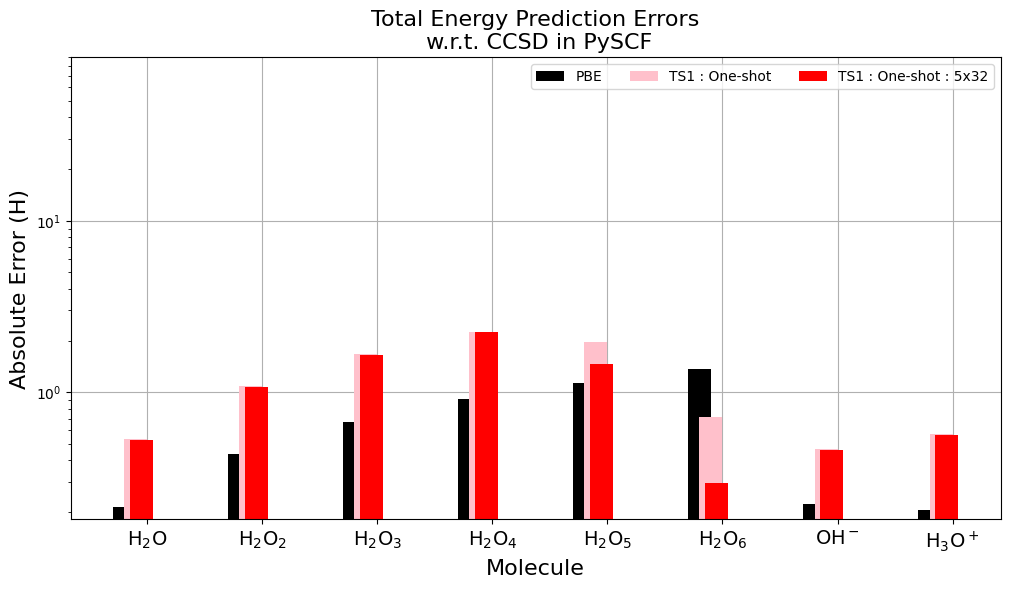

In [28]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_system_ticklabels = ['H$_2$O', 'H$_2$O$_2$', 'H$_2$O$_3$', 'H$_2$O$_4$', 'H$_2$O$_5$', 'H$_2$O$_6$', 'OH$^-$', 'H$_3$O$^+$']

ax.set_xticks(np.arange(1, len(relevant_systems)+2), labels=relevant_system_ticklabels+[''], fontsize=14)
Energy_conv =  1 
for idx, sys in enumerate(relevant_systems):
    pbe_err = abs(cc_ens[sys] - pbe_ens[sys][0])*Energy_conv
    o1os_err = abs(cc_ens[sys] - o1_os_ens[sys][0])*Energy_conv
    o1oslg_err = abs(cc_ens[sys] - o1_os_lg_ens[sys][0])*Energy_conv
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        ax.bar( (idx+1)-0.1, o1os_err, facecolor='pink', width=0.2, label = 'TS1 : One-shot')
        ax.bar( (idx+1)-0.05, o1oslg_err, facecolor='r', width=0.2, label = 'TS1 : One-shot : 5x32')
        # ax.bar( (idx+1), pre_err, facecolor='g', width=0.2, label='Pre-trained')
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2, label='Optimized[TE]')
        # ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2, label='Optimized[TE+Rxn]')
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2, label='Optimized[Rxn]')
    else:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        ax.bar( (idx+1)-0.1, o1os_err, facecolor='pink', width=0.2)
        ax.bar( (idx+1)-0.05, o1oslg_err, facecolor='r', width=0.2)
        # ax.bar( (idx+1), pre_err, facecolor='g', width=0.2)
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2)
        # ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2)
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend(ncol = 4)
ax.set_yscale('log')
ax.set_ylim(None, 9e1)
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_title('Total Energy Prediction Errors\n w.r.t. CCSD in PySCF', fontsize=16)

Finding errors for -1H2O2 + 2H2O with reference 0.007926693227091634
Finding errors for -1H2O3 + 3H2O with reference 0.025032669322709162
Finding errors for -1H2O4 + 4H2O with reference 0.043590438247011955
Finding errors for -1H2O5 + 5H2O with reference 0.057177689243027886
Finding errors for -1H2O6 + 6H2O with reference 0.07328764940239044


Text(0.5, 1.0, 'Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values')

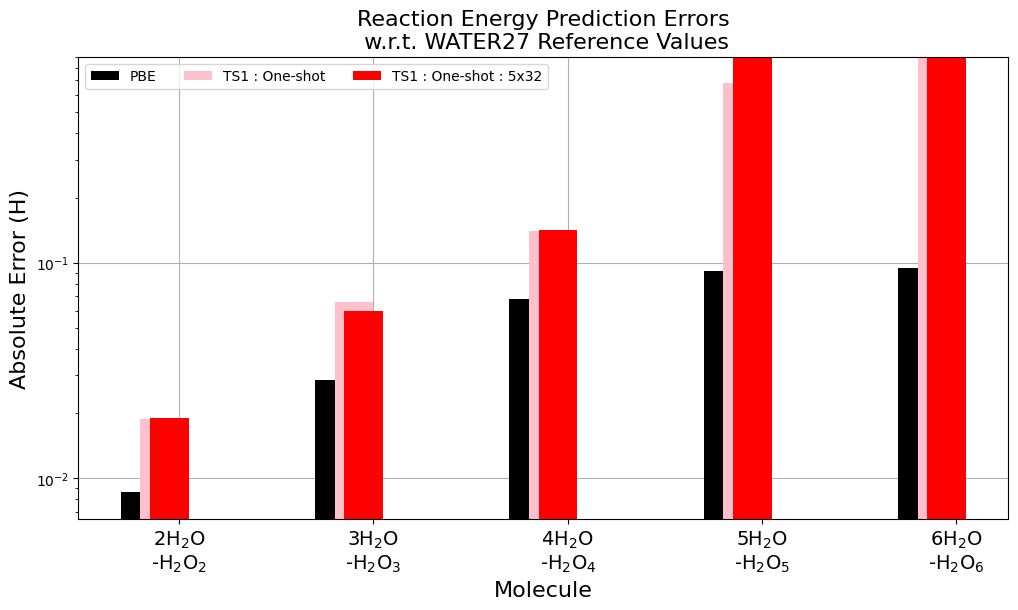

In [29]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_rxn_ticklabels = ['2H$_2$O\n-H$_2$O$_2$', '3H$_2$O\n-H$_2$O$_3$',
                           '4H$_2$O\n-H$_2$O$_4$', '5H$_2$O\n-H$_2$O$_5$',
                           '6H$_2$O\n-H$_2$O$_6$',]
ax.set_xticks(np.arange(1, len(relevant_reactions)+2), labels=relevant_rxn_ticklabels+[''], fontsize=14)

for idx, rxn in enumerate(relevant_reactions):
    sys1, h2o = rxn['systems']
    sys1mult, h2omult = rxn['stoichiometry']
    rxn_ref = rxn['reference']/627.5
    print('Finding errors for {}{} + {}{} with reference {}'.format(sys1mult,sys1,h2omult,h2o,rxn_ref))
    pbe_h = pbe_ens[sys1][0]*sys1mult + pbe_ens[h2o][0]*h2omult
    o1os_h = o1_os_ens[sys1][0]*sys1mult + o1_os_ens[h2o][0]*h2omult
    o1oslg_h = o1_os_lg_ens[sys1][0]*sys1mult + o1_os_lg_ens[h2o][0]*h2omult

    pbe_err = abs(pbe_h - rxn_ref)
    o1os_err = abs(o1os_h - rxn_ref)
    o1oslg_err = abs(o1oslg_h - rxn_ref)
    
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        ax.bar( (idx+1)-0.1, o1os_err, facecolor='pink', width=0.2, label = 'TS1 : One-shot')
        ax.bar( (idx+1)-0.05, o1oslg_err, facecolor='r', width=0.2, label = 'TS1 : One-shot : 5x32')
        # ax.bar( (idx+1), pre_err, facecolor='g', width=0.2, label='Pre-trained')
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2, label='Optimized[TE]')
        # ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2, label='Optimized[TE+Rxn]')
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2, label='Optimized[Rxn]')
    else:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        ax.bar( (idx+1)-0.1, o1os_err, facecolor='pink', width=0.2)
        ax.bar( (idx+1)-0.05, o1oslg_err, facecolor='r', width=0.2)
        # ax.bar( (idx+1), pre_err, facecolor='g', width=0.2)
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2)
        # ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2)
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend(ncol=4)
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_yscale('log')
ax.set_ylim(None, 9e-1)
ax.set_title('Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values', fontsize=16)